Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 43881.8008 - mean_absolute_percentage_error: 77.0846 - val_loss: 2879.4624 - val_mean_absolute_percentage_error: 24.6885 - learning_rate: 0.0100
Epoch 2/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5256.7603 - mean_absolute_percentage_error: 25.4134 - val_loss: 2273.1306 - val_mean_absolute_percentage_error: 20.8494 - learning_rate: 0.0099
Epoch 3/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5185.8022 - mean_absolute_percentage_error: 24.1396 - val_loss: 2209.7595 - val_mean_absolute_percentage_error: 19.8461 - learning_rate: 0.0098
Epoch 4/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5011.2671 - mean_absolute_percentage_error: 22.4788 - val_loss: 2101.2732 - val_mean_absolute_percentage_error: 19.7057 - learning_rate: 0.0097
Epoch 5/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4987.2031 - mean_absolute_percentage_error: 21.8648 - val_loss: 2120.0049 - val_mean_absolute_percentage_error: 19.5918 - learning

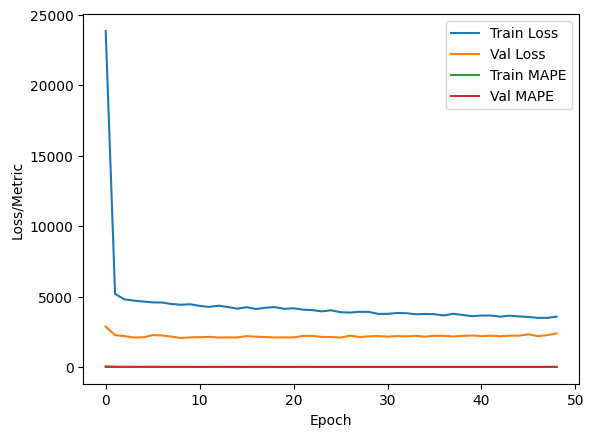

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE on validation set: 19.27%
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [9]:
import pandas as pd
import numpy as np
from numpy import typing
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
kiwo_url = '../../Data/kiwo.csv'
umsatz_url = '../../Data/train.csv'
wetter_url = '../../Data/wetter.csv'
test_url = '../../Data/test.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)
df_test = pd.read_csv(test_url)

# Merge data
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

def prepare_data(data):
    data['Datum'] = pd.to_datetime(data['Datum'])
    
    # One-hot encode day and month
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    day_dummies = pd.get_dummies(data['DayOfWeek'], prefix='Day')
    month_dummies = pd.get_dummies(data['Month'], prefix='Month')
    
    # Basic features
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)
    data['Temperatur'] = data['Temperatur'].fillna(data['Temperatur'].mean())
    data['Windgeschwindigkeit'] = data['Windgeschwindigkeit'].fillna(data['Windgeschwindigkeit'].mean())
    
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'IsWeekend', 'KielerWoche']
    feature_df = pd.concat([day_dummies, month_dummies, data[numerical_cols]], axis=1)
    
    return feature_df

# Prepare datasets
X_train = prepare_data(df_train)
y_train = df_train['Umsatz']
X_test = prepare_data(df_test)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape data for LSTM layer (samples, timesteps, features)
timesteps = 1  # Since we are predicting based on single timestep data
X_train = X_train.reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], timesteps, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], timesteps, X_test.shape[1]))

# Define custom MAPE metric
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-8, tf.float32.max))
    return 100. * tf.reduce_mean(diff)

# Build LSTM model
model = tf.keras.Sequential([
    LSTM(50, activation='relu', input_shape=(timesteps, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[mean_absolute_percentage_error])

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mean_absolute_percentage_error'], label='train_mape')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='val_mape')
plt.xlabel('Epoch')
plt.ylabel('Loss/Metric')
plt.legend()
plt.show()

# Load the best model
model.load_weights('best_model.keras')

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Add predictions to the test dataframe
df_test['Predicted_Umsatz'] = test_predictions

# Save the test dataframe with predictions
df_test.to_csv('predicted_test.csv', index=False)

# Evaluate the model on validation set
val_predictions = model.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
print(f'MAPE on validation set: {val_mape:.2f}%')